## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(7, 8):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:14<00:00,  5.15it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_7"])
layer_hs_array.shape

(10000, 267264)

## Layer 7 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

# dim_reduced_vecs = layer_hs_array

random_projector = GaussianRandomProjection(random_state = 42)
dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 7894)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 7894)
(8000,)
(2000, 7894)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 7894D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.10 s
Outer iteration 0 / 10
  Iteration 19 (0.25 s, search 0.14 s): objective=2007.34 imbalance=1.080 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (0.50 s, search 0.27 s): objective=2013.34 imbalance=1.184 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (0.75 s, search 0.41 s): objective=2009.06 imbalance=1.040 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (1.00 s, search 0.54 s): objective=2009.49 imbalance=1.190 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (1.25 s, search 0.67 s): objective=2001.26 imbalance=1.494 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (1.50 s, search 0.81 s): objective=1997.58 imbalance=1.686 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (1.75 s, search 0.95 s): objective=2010.03 imbalance=1.366 n

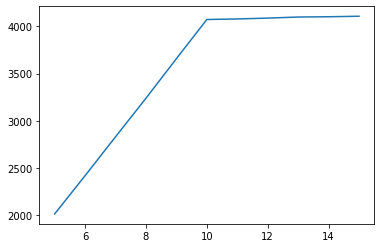

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 7894D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.04 s
Outer iteration 0 / 10
  Iteration 19 (0.50 s, search 0.27 s): objective=4060.07 imbalance=1.530 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (0.99 s, search 0.54 s): objective=4065.88 imbalance=1.130 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (1.53 s, search 0.84 s): objective=4066.22 imbalance=1.320 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 10
  Iteration 19 (2.07 s, search 1.12 s): objective=4072.97 imbalance=1.198 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (2.57 s, search 1.39 s): objective=4025.95 imbalance=2.501 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (3.06 s, search 1.66 s): objective=4063.26 imbalance=1.454 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (3.56 s, search 1.93 s): obj

4072.969482421875

In [15]:
kmeans.centroids #cluster centers

array([[ 0.00072117, -0.01702505,  0.01421015, ..., -0.01259057,
        -0.0074159 ,  0.00208717],
       [ 0.00515504, -0.01426059,  0.00612534, ..., -0.01137241,
        -0.00495147,  0.00368165],
       [ 0.00733705, -0.01802784,  0.01686674, ..., -0.00886045,
        -0.01178247,  0.0054739 ],
       ...,
       [ 0.01432995, -0.00941101,  0.02120697, ..., -0.00023613,
        -0.00527151,  0.00663354],
       [ 0.00604765, -0.01240058,  0.01671424, ..., -0.00180755,
        -0.01497418,  0.00689451],
       [ 0.00940363, -0.00636714,  0.0212569 , ...,  0.00142964,
        -0.00190154, -0.00306578]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

0.9999999
1.0
0.99999994
1.0
1.0000001
0.99999994
1.0000001
0.9999998
1.0
0.9999999


In [17]:
kmeans.obj #inertia at each iteration

array([2356.34521484, 3923.12182617, 4023.43310547, 4038.67260742,
       4046.828125  , 4050.94799805, 4053.79077148, 4055.93481445,
       4057.31152344, 4058.52270508, 4059.4074707 , 4059.73242188,
       4059.85742188, 4059.93286133, 4059.98632812, 4060.03125   ,
       4060.05371094, 4060.06665039, 4060.06762695, 4060.07202148,
       2314.61474609, 3930.16821289, 4020.91772461, 4046.39672852,
       4054.73266602, 4056.80151367, 4058.47802734, 4059.67089844,
       4060.2746582 , 4060.82177734, 4061.69165039, 4063.62060547,
       4064.86523438, 4065.22875977, 4065.4309082 , 4065.55517578,
       4065.66870117, 4065.76977539, 4065.82421875, 4065.87670898,
       2294.60839844, 3939.39135742, 4030.20825195, 4050.01513672,
       4058.88427734, 4063.39550781, 4064.99853516, 4065.53588867,
       4065.76147461, 4065.84301758, 4065.91601562, 4065.97705078,
       4066.01635742, 4066.06005859, 4066.08422852, 4066.10449219,
       4066.15039062, 4066.17382812, 4066.19873047, 4066.22412

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

6    1350
2    1190
4    1110
1    1088
5     825
7     744
0     474
9     449
3     438
8     332
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[3, 2, 6, 10, 1, 5, 9, 6, 10, 3]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 3, 1: 2, 2: 6, 3: 10, 4: 1, 5: 5, 6: 9, 7: 6, 8: 10, 9: 3}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 6,  6,  6, ...,  6, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.21625
Prompt 2 Accuracy:  0.2075
Prompt 3 Accuracy:  0.825
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.415
Prompt 6 Accuracy:  0.47625
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.34125
Prompt 10 Accuracy:  0.81375


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.3295


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

6    345
2    309
1    294
4    233
5    208
7    185
3    127
0    116
9    106
8     77
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 9,  2,  6, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.135
Prompt 2 Accuracy:  0.195
Prompt 3 Accuracy:  0.775
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.455
Prompt 6 Accuracy:  0.44
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.35
Prompt 10 Accuracy:  0.82


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.317


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

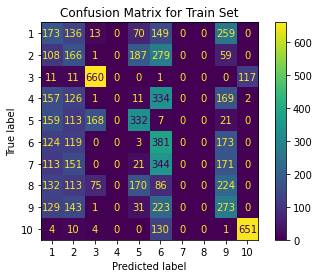

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

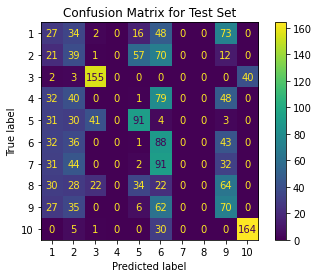

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()